In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
import random
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
from keras import optimizers
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages

1.13.1


## Import data:
Using ShowJetsData_full.npz to build the CNN.

In [2]:
grid = 16
data= np.load('data/ShowJetsData_full.npz')

In [3]:
data_dic={key : data[key]  for key in data.keys()}
n_data=len(data_dic['labels'])
# Sum all signal labels
data_dic['labels']=np.array([[ele[0],np.sum(ele[1:])] for ele in data_dic['labels']]).astype(int)

## Balance and Normalize data and split into train and test

Build list of signal and background indices, balance them, shuffle and combine back.

In [4]:
random.seed(1)
ind_sig_inb=np.argwhere(data_dic['labels'][:,1]==1)[:,0]
ind_bkg=np.argwhere(data_dic['labels'][:,0]==1)[:,0]
ind_sig=random.choices(ind_sig_inb,k=len(ind_bkg))
ind=np.concatenate((ind_bkg,ind_sig),axis=0)
np.random.shuffle(ind)

In [5]:
print(len(ind_bkg))
print(len(ind_sig))

496341
496341


In [6]:
split=0.9

Build two dictionaries with train and test data.

In [10]:
data_train={}
data_test={}
cut=int(split*len(ind))
for key in data_dic.keys():
    sub=data_dic[key][ind]
    if key=='jetImages':
        minn=np.min(sub)
        maxx=np.max(sub)
        data_train[key]=(sub[:cut]-minn)/(maxx-minn)
        data_test[key]=(sub[cut:]-minn)/(maxx-minn)
    else:
        minn=np.min(sub,axis=0)
        maxx=np.max(sub,axis=0)
        data_train[key]=(sub[:cut]-minn)/(maxx-minn)
        data_test[key]=(sub[cut:]-minn)/(maxx-minn)

In [14]:
n_train=len(data_train['jetPt'])
print(n_train)
n_test=len(data_test['jetPt'])
print(n_test)

893413
99269


## Select Features for Model

In [16]:
[key for key in data_dic.keys()]

['jetImages',
 'jetPt',
 'jetEta',
 'jetPhi',
 'tau21',
 'chMult',
 'neutMult',
 'phoMult',
 'eleMult',
 'muMult',
 'jetpull',
 'labels']

In [17]:
# features will be loaded into X
features=['jetImages','muMult']
# label into Y
label=['labels']

In [18]:
X_train=[data_train[key] for key in features]
X_test=[data_test[key] for key in features]
Y_train=[data_train[key] for key in label]
Y_test=[data_test[key] for key in label]
# Reshape pictures for CNN
X_train[0]=X_train[0].reshape(n_train, grid, grid, 1)
X_test[0]=X_test[0].reshape(n_test, grid, grid, 1)

In [19]:
dim=[1 if ele[0].shape==() else ele[0].shape[0] for ele in X_train]
for i in range(1,len(X_train)):
    X_train[i]=X_train[i].reshape(len(X_train[i]),dim[i])
for i in range(1,len(X_test)):
    X_test[i]=X_test[i].reshape(len(X_test[i]),dim[i])

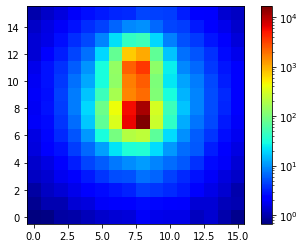

In [23]:
#plot input signal and background
sig_images=0
bkg_images=0
for i in range(n_train):
    if Y_train[0][i][1]==1:
        sig_images +=X_train[0][i]
    else:
        bkg_images +=X_train[0][i]
#signal
display_sig = sig_images.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

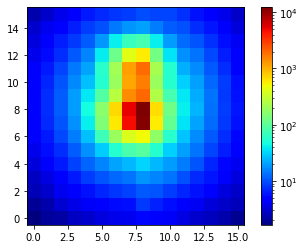

In [24]:
#background
display_bkg = bkg_images.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

### Build DNN:

In [25]:
def build_model():
    input2=[layers.Input(shape=(len(X_train[i][0]),)) for i in range(1,len(X_train))]
    input1 = layers.Input(shape = (grid, grid,1))
    x = layers.Conv2D(32, (5, 5), activation='relu',padding='same')(input1)
    x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x1 = layers.Flatten()(x)
    x = layers.concatenate(inputs = [x1]+input2,axis=-1)
    x = layers.Dense(256, activation='relu')(x)
    output = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inputs=[input1] +input2, outputs=output)
    opt=keras.optimizers.Adam(lr=0.0005,beta_1=0.9, beta_2=0.9, amsgrad=False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['binary_crossentropy', 'accuracy'])
    return model

Initialize model:

In [26]:
circleCNN = build_model()

Instructions for updating:
Colocations handled automatically by placer.


Test model's prediction $before$ training:

In [29]:
X_batch =[ele[:10] for ele in X_train]
Y_batch =[ele[:10] for ele in Y_train]
example_result = circleCNN.predict(x = X_batch)
results = circleCNN.evaluate(x = X_batch, y =Y_batch )
print(example_result)
print(results)

10/10 [==============================] - 0s 329us/step
[[0.49992698 0.500073  ]
 [0.49985814 0.5001419 ]
 [0.49993443 0.50006557]
 [0.4999344  0.5000656 ]
 [0.5000957  0.4999043 ]
 [0.5000336  0.49996635]
 [0.50004405 0.49995595]
 [0.49995524 0.50004476]
 [0.500003   0.499997  ]
 [0.49998116 0.5000189 ]]
[0.6931343078613281, 0.6931343078613281, 0.4000000059604645]


Now train! (warning: if building CNN, computer tends to get loud)

In [30]:
#circleCNN = keras.models.load_model('model/CNN_full.h2')

In [31]:
#circleCNN.save("model/CNN_full.h3")

In [ ]:
# class PrintDot(keras.model.save(filepath)callbacks.Callback):
#     def on_epoch_end(self, epoch, logs):
#         if epoch % 100 == 0:
#             print('')
#         print('.', end='')
    
checkpoint_path = "model/CNN_full.h2"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
EPOCHS = 20
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
history = circleCNN.fit(
  X_train, Y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose = 1,
  callbacks=[early_stop, model_checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 714730 samples, validate on 178683 samples
Epoch 1/20
708640/714730 [============================>.] - ETA: 6s - loss: 0.5522 - binary_crossentropy: 0.5522 - acc: 0.7217

Load best weights.

In [29]:
!ls model
best_model = keras.models.load_model('model/CNN_full.h2')
best_model.summary()
results = best_model.evaluate(X_test, Y_test)
print(results)

CNN_full.h1  CNN_full.h2  CNN_full.h3
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16, 16, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   832         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 32)   9248        conv2d_2[0][0]                   
_______________________________________________________________________

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

In [30]:
predict = best_model.predict(X_test)

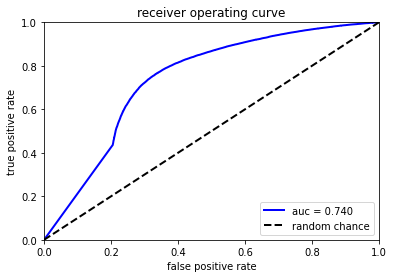

In [31]:
# Plot ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test[0][:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()